# Primer uporabe tekstovne vizualizacije

V tem zvezku demonstriramo delovanje metode za raziskovanje tekstovnih korpusov, ki temelji na metodi DocuCompass.

In [1]:
import sys 
sys.path.append('..')

from lib.text_exploration.doc_explorer import DocExplorer, LemmaTokenizer, remove_non_alphabetic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from nltk.corpus import reuters
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(1)
%matplotlib inline  

Za demonstracijo uporabimo podmnožico finančnih novic Reuters. Podmnožica je določena na podlagi ročno izbranih kategorij.

In [2]:
selected_categories = ['housing', 'gas', 'tea', 'lumber', 'jobs', 'retail']
texts = []
categories = []
for i,c in enumerate(selected_categories):
    for file in reuters.fileids(c):
        texts.append(reuters.raw(file))
        categories.append(c)

Poleg tekstov metoda kot vhod sprejme poljubno projekcijo dokumentov in poljubno razvrstitev dokumentov v skupine. Za pridobitev teh najprej izvedemo osnovno preobdelavo besedil, ki vključuje odstranitev nečrkovnih znakov, pretvorbo v majhne črke in pretvorbo v osnovno obliko besed (lematizacijo). Nato za dokumente izračunamo vektorje značilk tf-idf. Ti vektorji predstavljajo relativne ferkvence besed v dokumentih, obtežene z redkostmi teh besed v celotnem korpusu. Besede, ki se v dokumentu pojavijo pogosto in se v celotnem korupusu pojavijo redko imajo torej relativno visoke vrednosti. S tf-idf matriko lahko nato pridobimo skupine dokumentov z uporabo metode DBSCAN.

In [3]:
tf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), preprocessor=remove_non_alphabetic, max_df=0.5)
tf_idf_matrix = tf_vectorizer.fit_transform(texts).toarray()

dbscan = DBSCAN(eps=1, min_samples=4)
clusters = dbscan.fit_predict(tf_idf_matrix)

Za projekcijo dokumentov prav tako uporabimo tf-idf matriko. Na razpolago imamo več metod za projeciranje. V naslednjih korakih primerjamo tri: t-SNE, UMAP in MDS. Ker imamo v uporabljenih podatkih znane razrede lahko te uporabimo pri ocenjevanju kvalitete projekcije, saj bi radi da so točke z enakih razredov bližje kot točke z različnih razredov. Ta kriterij aproksimiramo z natančnostjo KNN klasifikatorja na dani projekciji. Poleg tega projekcije tudi vizualno ocenimo, saj je glavni namen projekcije v našem primeru ravno pomoč človeku pri razumevanju podatkov.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
def evaluate_projection_knn(X_em, y, n=5):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_em, y)
    return knn.score(X_em, y)

Na danih podatkih t-SNE in UMAP najdeta precej dobri projekciji, saj bližnje točke večinoma pripadajo istim razredom. MDS projekcija je relativno precej slabša, saj ima veliko večje število pomešanih točk. Če nadalnje primerjamo rezulatate metod t-SNE in UMAP opazimo, da UMAP med različnimi skupinami naredi nekoliko večje prostore, kar pomeni še boljšo vizualno ločitev. Našo vizualno ocenitev podkrepijo tudi natančnosti KNN klasifikatorjev za dane projekcije.

t-SNE KNN CA: 0.877
UMAP KNN CA: 0.908
MDS KNN CA: 0.662


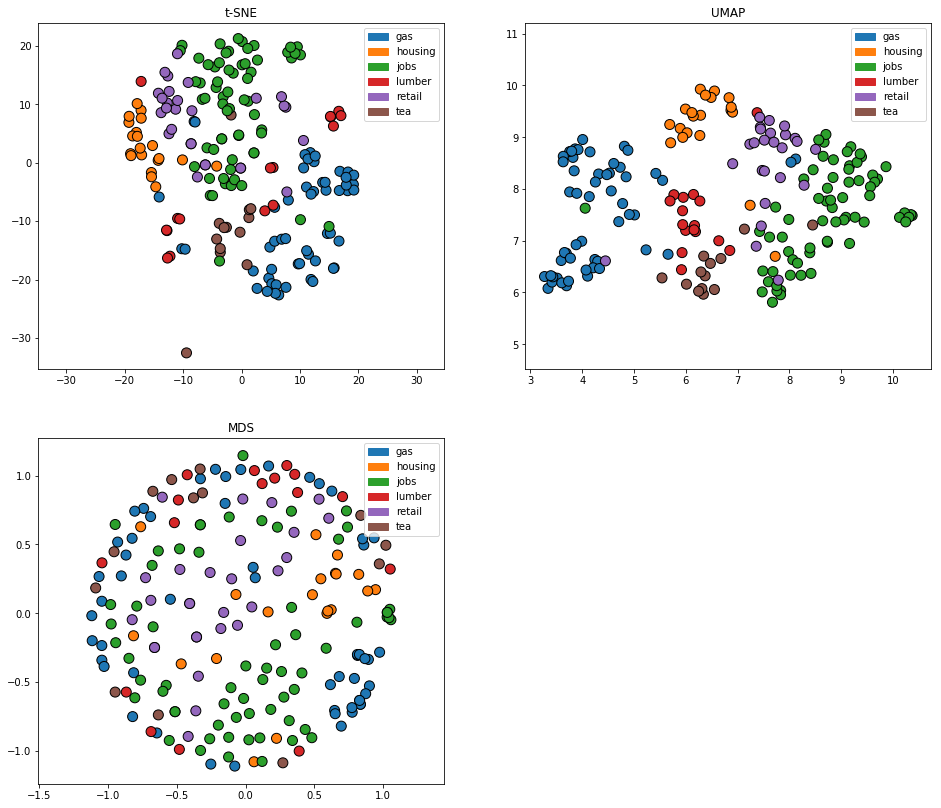

In [5]:
fig = plt.figure(num=None, figsize=(16,14))
ax1 = fig.add_subplot(221) 
ax2 = fig.add_subplot(222) 
ax3 = fig.add_subplot(223) 


#t-SNE
tsne = TSNE(perplexity=20, early_exaggeration=30)
X_em1 = tsne.fit_transform(tf_idf_matrix)

doc_explorer = DocExplorer()
doc_explorer.fit(texts, X_em=X_em1, clusters=clusters, ax=ax1)
doc_explorer.plot_static(classes=categories, plot_keywords=False ,s=100)
ax1.set_title('t-SNE')
print("t-SNE KNN CA: {:.3}".format(evaluate_projection_knn(X_em1, categories)))

#UMAP
from umap import UMAP
umap = UMAP(n_neighbors=25, min_dist=0.1)
X_em2 = umap.fit_transform(tf_idf_matrix)

doc_explorer.fit(texts, X_em=X_em2, clusters=clusters, ax=ax2)
doc_explorer.plot_static(classes=categories, plot_keywords=False ,s=100)
ax2.set_title('UMAP')
print("UMAP KNN CA: {:.3}".format(evaluate_projection_knn(X_em2, categories)))

#MDS
from sklearn.manifold import MDS
mds = MDS()
X_em3 = mds.fit_transform(tf_idf_matrix)

doc_explorer.fit(texts, X_em=X_em3, clusters=clusters, ax=ax3)
doc_explorer.plot_static(classes=categories, plot_keywords=False ,s=100)
ax3.set_title('MDS')
print("MDS KNN CA: {:.3}".format(evaluate_projection_knn(X_em3, categories)))

Na podlagi rezultatov v nadaljevanju uporabimo projekcijo UMAP.

In [6]:
X_em = X_em2

Dokumente, projekcije in skupine lahko nato vstavimo v našo implementacijo metode za raziskovanje korpusov. Statičen del vizualizacije za vsako skupino dokumentov najde ključne besede ter jih prikaže na točkovnem prikazu. Pri privzetih nastavitvah metoda za pridobitev ključnih besed uporabi tf-idf matriko. Poleg tega lahko v vizualizacijo vstavimo tudi poljubne razrede (ponavadi razredni atribut ali pa najdene skupine) po katerih bodo točke obarvane. Opazimo, da je ujemanje med obarvanjem po razredih in napisih tukaj precej dobro in smiselno.

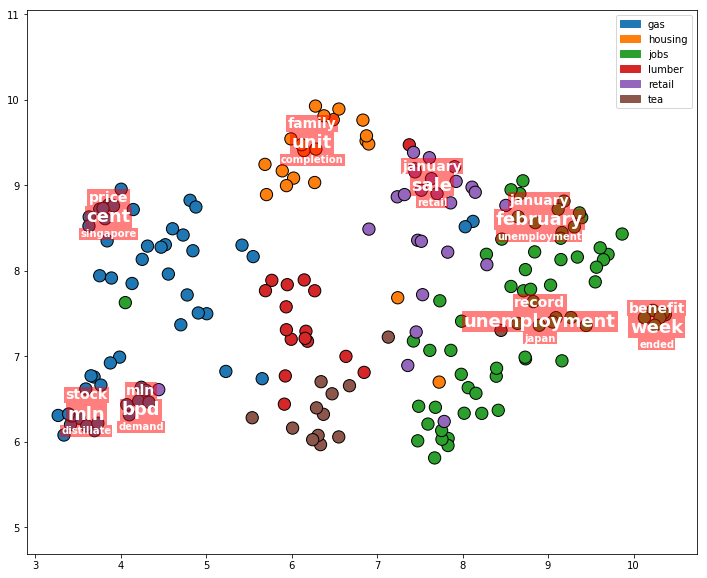

In [7]:
doc_explorer = DocExplorer()
doc_explorer.fit(texts, X_em=X_em, clusters=clusters)
fig, ax = doc_explorer.plot_static(classes=categories, s=150)

Za pridobitev ključnih besed lahko uporabimo tudi metodo G2, ki temelji na primerjavi ponovitev besed v skupini s ponovitvijo besed izven skupine. Opazimo, da so rezultati precej podobni metodi tf-idf, kljub temu pa je nekaj razlik.

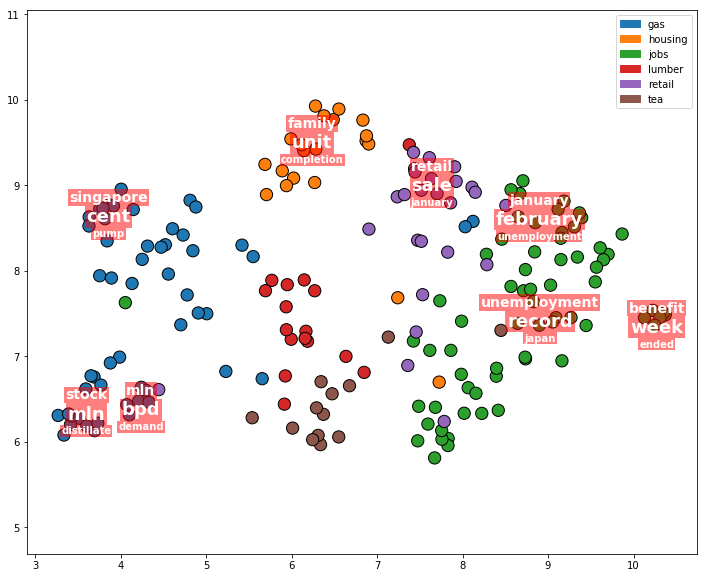

In [8]:
doc_explorer = DocExplorer(method='g2')
doc_explorer.fit(texts, X_em=X_em, clusters=clusters)
fig, ax = doc_explorer.plot_static(classes=categories, s=150)

Dinamični del vizualizacije najde ključne besede za izbrane točke na vizualizaciji. Metoda zahteva, da podamo središče in radij kroga na vizalizaciji. Izbrane so vse točke, ki so znotraj tega kroga. Ključne besede so pridobljene po enaki metodi, kot za statičen del vizualizacije.

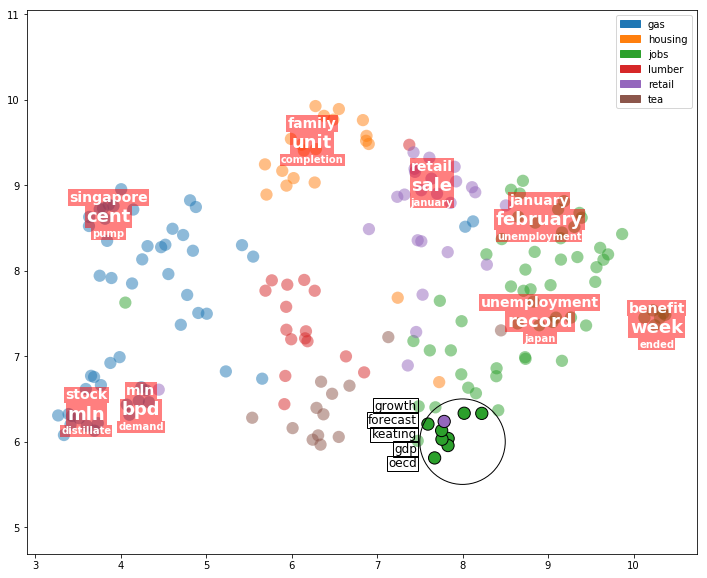

In [9]:
fig, ax = doc_explorer.plot_dynamic(8,6,0.5)
fig

Lahko uporabimo tudi interaktivno vizualizacijo, ki nam omogoča, da s klikom spremenimo središče kroga za izbiro.

<IPython.core.display.Javascript object>


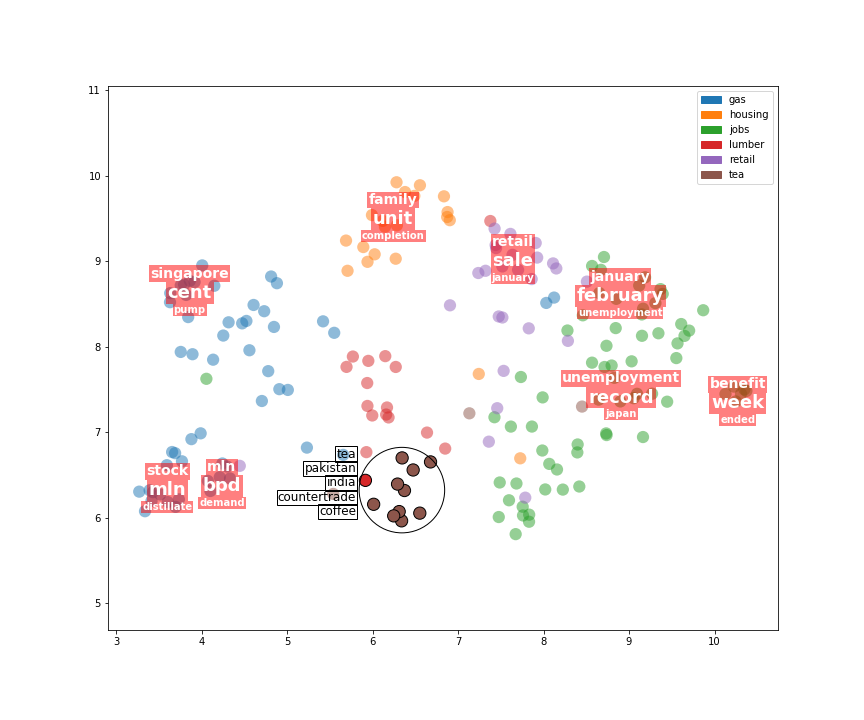

In [11]:
%matplotlib notebook

doc_explorer.fit(texts, X_em=X_em, clusters=clusters)
doc_explorer.plot_static(classes=categories, s=150)
fig, ax = doc_explorer.plot_interactive(r=0.5)

V zadnjem delu poizkusimo replicirati vizualizacijo iz dela Qi Han. V delu je bila uporabljena podatkovna množica povzetkov in naslovov s preteklih konferenc o vizualizacijah (IEEE VIS).  

In [12]:
vis_papers = pd.read_csv('../data/IEEE VIS papers 1990-2016 - Main dataset.csv')
drop_idx = vis_papers.index[vis_papers["Abstract"].isnull()]
vis_papers.drop(drop_idx, inplace=True)
#vis_papers["Abstract"].fillna("", inplace=True)
vis_papers = (vis_papers["Paper Title"] + " " + vis_papers["Abstract"]).tolist()

V delu značilke dokumentov predstavijo s tf-idf matriko, omenijo pa tudi uporabo lematizacije.

In [13]:
tf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), preprocessor=remove_non_alphabetic, max_df=0.075, min_df=5, max_features=500)
tf_idf_matrix = tf_vectorizer.fit_transform(vis_papers).toarray()

Za projekcijo je uporabljena metoda t-SNE.

In [14]:
tsne = TSNE(perplexity=30, early_exaggeration=10, learning_rate=200)
X_em = tsne.fit_transform(tf_idf_matrix)

Za razvrščanje je uporabljena metoda DBSCAN.

In [15]:
dbscan = DBSCAN(eps=0.9, min_samples=5)
clusters = dbscan.fit_predict(tf_idf_matrix)

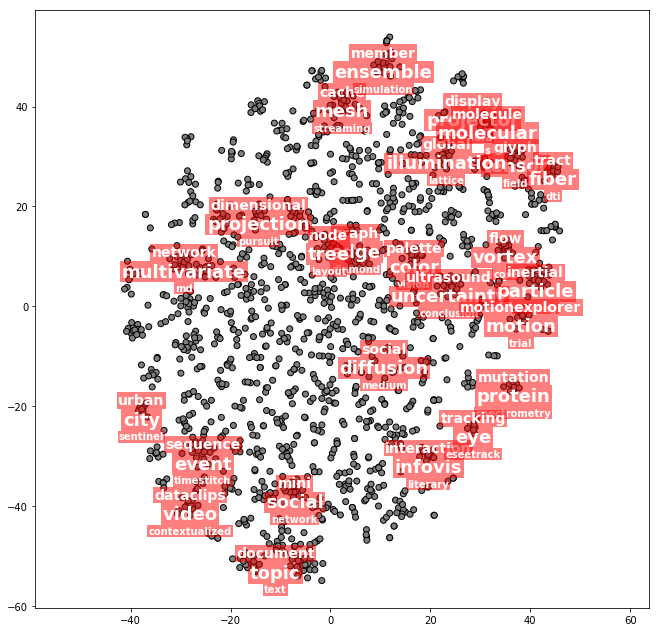

In [16]:
%matplotlib inline  
fig, ax = plt.subplots(figsize=(11,11))
doc_explorer = DocExplorer(method='g2')
doc_explorer.fit(vis_papers, X_em=X_em, clusters=clusters, ax=ax)
fig, ax = doc_explorer.plot_static()
#fig, ax = doc_explorer.plot_interactive(r=5)

Če vizualizacijo primerjamo s tisto v delu, najdemo kar nekaj podobnih oznak/skupin, hkrati pa tudi mnogo različnih. Natančna replikacija je v tem primeru zelo težka, saj uporabljene metode in njihovi parametri v delu niso natačno opisani.

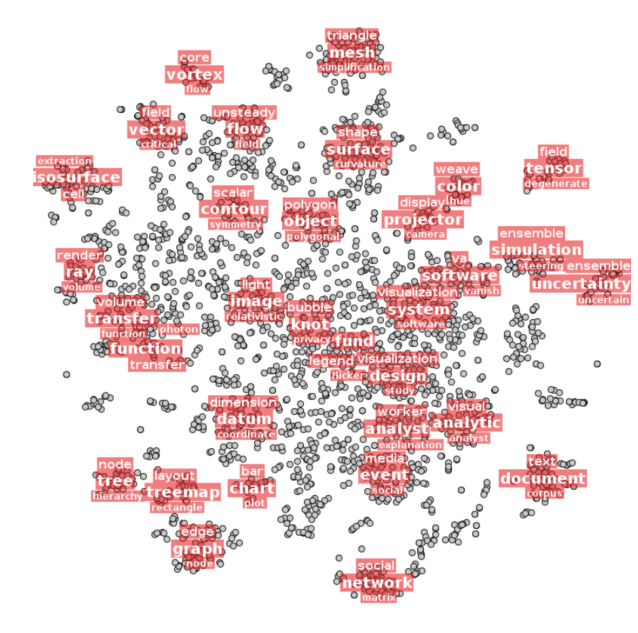

In [20]:
import matplotlib.image as mpimg
img=mpimg.imread('han2018.png')
plt.figure(figsize=(11,11))
plt.imshow(img, interpolation='bilinear')
plt.axis('off')
plt.show()